In [1]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
tf.test.gpu_device_name()

''

In [2]:
# Load accelData from pickle

import pickle
import numpy as np
import matplotlib.pyplot as plt

# open accelData pickle
import pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

In [3]:
# Remove time column from accelData Measurements
accelData['Measurements with Time'] = accelData['Measurements']

for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

In [4]:
# Define a function that does the following:

# Takes a set of trials and trial labels : accelData['Measurements'], accelData['Abnormal']
# Splits sets into training and testing datasets

# For training set:
# Create windows of size windowSize and stride stride
# The windows should be stored in a list: trainWindows
# Each window label should be the label of the trial it came from
# The window labels should be stored in a list: trainWindowLabels
# Normalise each window
# Create a deep learning model and train on the windows and window labels

# For testing set:
# For each trial:
# Create windows of size windowSize and stride stride
# The windows should be stored in a list: testWindows
# Each window label should be the label of the trial it came from
# The window labels should be stored in a list: testWindowLabels
# Normalise each window
# Predict the label of each window using the trained model
# For each trial, calculate the proportion of windows that were classified as abnormal
# Based on the proportion, classify the trial as 0 (normal), 0.5 (borderline), or 1 (abnormal)
# Compare the classification to the true label and calculate the accuracy
# Return the accuracy

# The function should return the accuracy of the model on the testing set
# The function should also return the proportion of windows classified as abnormal for each trial in the testing set

# imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam




def normaliseWindows(windows):
    # Check if any NaNs are present in the windows
    #for window in windows:
        #if window.isnull().values.any():
            #print('NaNs found in windows')
    for i in range(len(windows)):
        if i%(len(windows)//100) == 0:
            print(f'Normalising window {i} of {len(windows)}')
        windows[i] = (windows[i] - windows[i].mean()) / windows[i].std()
        if windows[i].isnull().values.any():
            print('NaNs found in normalised windows')

            # print number of NaNs in each window
            print(window.isnull().sum())
    return windows

def windowModelling(windowSize, trainWindows, encodedLabels):
    # Create the model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(windowSize, 16)))
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(np.array(trainWindows), np.array(encodedLabels), epochs=1, verbose=1)

    return model

def windowClassification(trials, labels, windowSize, stride):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trials, labels, test_size=0.2, random_state=42)

    # Status update
    print('Data split into training and testing sets')

    

    # Split X_train into windows
    trainWindows = []
    trainWindowLabels = []
    for i in range(len(X_train)):
        windows = createWindows(X_train[i], windowSize, stride)
        trainWindows.extend(windows)
        labelArray = np.full(len(windows), y_train[i])
        # Convert labelArray to a list
        trainWindowLabels.extend(labelArray.tolist())
        

    # Convert trainWindowLabels to one-hot encoding
    encoder = LabelEncoder()
    encoder.fit(trainWindowLabels)
    encodedLabels = encoder.transform(trainWindowLabels)
    encodedLabels = to_categorical(encodedLabels)   
    print(encodedLabels)

    # Status update
    print('Training windows created')

    #Normalise trainWindows
    trainWindows = normaliseWindows(trainWindows)

    #PCA transform each window
    pca = PCA(n_components=4)
    for i in range(len(trainWindows)):
        trainWindows[i] = pca.fit_transform(trainWindows[i])
    
    # PCA transform each limb in each window from 4->1
    #for i in range(len(trainWindows)):
        

    # Status update
    print('Training windows normalised')

    model = windowModelling(windowSize, trainWindows, encodedLabels)

    # Split X_test into windows, ensuring that the windows are segmented by trial
    # Use nested list, where each element is a list of windows from a single trial
    testWindows = []
    testWindowLabels = []
    for i in range(len(X_test)):
        windows = createWindows(X_test[i], windowSize, stride)
        testWindows.append(windows)
        testWindowLabels.append(y_test[i])

    # Encode test window labels
    encoder = LabelEncoder()
    encoder.fit(testWindowLabels)
    encodedLabels = encoder.transform(testWindowLabels)
    encodedLabels = to_categorical(encodedLabels)
    
    # Normalise testWindows
    for i in range(len(testWindows)):
        testWindows[i] = normaliseWindows(testWindows[i])

    # Predict the label of each window using the trained model
    predictions = []
    
    for trial in testWindows:
        trialPredictions = model.predict(np.array(trial))
        predictions.append(trialPredictions)

    #print(predictions)


    trial_pred = []
    for i in range(len(predictions)):
        normalCount = 0
        borderLineCount = 0
        abnormalCount = 0
        for window in predictions[i]:
            if np.argmax(window) == 0:
                normalCount += 1
            elif np.argmax(window) == 1:
                abnormalCount += 1
            else:
                borderLineCount += 1
        
        if normalCount > abnormalCount and normalCount > borderLineCount:
            trial_pred.append(0.0)
        elif borderLineCount > normalCount and borderLineCount > abnormalCount:
            trial_pred.append(0.5)
        else:
            trial_pred.append(1.0)
    
    # Compare the classification to the true label and calculate the accuracy
    correct = 0
    for i in range(len(trial_pred)):
        if trial_pred[i] == y_test[i]:
            correct += 1
    accuracy = correct / len(y_test)
    

    return accuracy



    

In [23]:
print(accelData['Abnormal'])



[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


AttributeError: 'list' object has no attribute 'value_counts'

In [6]:
# Create a window generator function to save memory
def window_generator_old(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        for i in np.random.permutation(len(data)):
            print(f'Processing trial {i} of {len(data)}')
            windows = createWindows(data[i], windowSize, stride)
            for window in windows:
                # Normalize the window
                window_normalized = (window - np.mean(window)) / np.std(window)
                batch_features.append(window_normalized)
                batch_labels.append(labels[i])

                if len(batch_features) == batch_size:
                    print('Yielding batch')
                    print(np.array(batch_features).shape)
                    # Yield the batch data
                    yield np.array(batch_features), np.array(batch_labels)
                    batch_features = []
                    batch_labels = []

def window_generator(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        for i in np.random.permutation(len(data)):
            window = data[i]
            # Normalize the window
            window_normalized = (window - np.mean(window)) / np.std(window)
            batch_features.append(window_normalized)
            batch_labels.append(labels[i])

            if len(batch_features) == batch_size:
                print('Yielding batch')
                print(np.array(batch_features).shape)
                # Yield the batch data
                yield np.array(batch_features), np.array(batch_labels)
                batch_features = []
                batch_labels = []



from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from keras.optimizers import Adam

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=True)
    return model


def batchWindowClassification(trials, labels, windowSize, stride, batch_size=1000):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trials, labels, test_size=0.2, random_state=42)

    print(y_train)
    print(y_test)

    unique_labels = np.unique(np.concatenate((y_train, y_test)))
    num_classes = len(unique_labels)
    print(f"Number of unique classes: {num_classes}")

    # Prepare labels for training
    encoder = LabelEncoder()
    encoder.fit(np.concatenate((y_train, y_test)))    

    ''' # Encode training labels
    encoded_y_train = encoder.transform(y_train)
    encoded_y_train = to_categorical(encoded_y_train, num_classes=num_classes)

    # Encode testing labels
    encoded_y_test = encoder.transform(y_test)
    encoded_y_test = to_categorical(encoded_y_test, num_classes=num_classes)'''

    # Split X_train into windows
    trainWindows = []
    trainWindowLabels = []
    for i in range(len(X_train)):
        windows = createWindows(X_train[i], windowSize, stride)
        trainWindows.extend(windows)
        labelArray = np.full(len(windows), y_train[i])
        # Convert labelArray to a list
        trainWindowLabels.extend(labelArray.tolist())

    # encode trainWindowLabels
    encoded_trainWindowLabels = encoder.transform(trainWindowLabels)
    encoded_trainWindowLabels = to_categorical(encoded_trainWindowLabels, num_classes=num_classes)


    # Creating generators for training and validation
    train_gen = window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=batch_size)

    model = build_model((windowSize, 16), 3)

    # Assume your model is named 'model' and is already defined
    model.fit(train_gen, steps_per_epoch=max(1, len(trainWindows) // batch_size), epochs=10, verbose=1)    

    # Split X_train into windows
    testWindows = []
    testWindowLabels = []
    for i in range(len(X_test)):
        windows = createWindows(X_test[i], windowSize, stride)
        testWindows.extend(windows)
        labelArray = np.full(len(windows), y_test[i])
        # Convert labelArray to a list
        testWindowLabels.extend(labelArray.tolist())

    # encode testWindowLabels
    encoded_testWindowLabels = encoder.transform(testWindowLabels)
    encoded_testWindowLabels = to_categorical(encoded_testWindowLabels, num_classes=num_classes)

    # Creating generators for testing
    test_gen = window_generator(testWindows, encoded_testWindowLabels, windowSize, stride, batch_size=batch_size)
    test_steps = max(1, len(testWindows) // batch_size)  # Ensure at least 1 step


    # Evaluate the model
    accuracy = model.evaluate(test_gen, steps= test_steps, verbose=1)

    # Print out predictions
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)

    # transform predictions to labels
    predictions = np.argmax(predictions, axis=1)
    predictions = encoder.inverse_transform(predictions)
    print(predictions)

    return accuracy, model

# Test the function
accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 100, 50)

print("Accuracy:", accuracy)






        

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
Yielding batch
(1000, 100, 16)
Epoch 1/10
Yielding batch
(1000, 100, 16)
  2/286 [..............................] - ETA: 2:53 - loss: 1.7806 - accuracy: 0.4060Yielding batch
(1000, 100, 16)
  3/286 [..............................] - ET

KeyboardInterrupt: 

Yielding batch
(1000, 100, 16)


In [4]:
# Create a window generator function to save memory
def window_generator_old(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        for i in np.random.permutation(len(data)):
            print(f'Processing trial {i} of {len(data)}')
            windows = createWindows(data[i], windowSize, stride)
            for window in windows:
                # Normalize the window
                window_normalized = (window - np.mean(window)) / np.std(window)
                batch_features.append(window_normalized)
                batch_labels.append(labels[i])

                if len(batch_features) == batch_size:
                    print('Yielding batch')
                    print(np.array(batch_features).shape)
                    # Yield the batch data
                    yield np.array(batch_features), np.array(batch_labels)
                    batch_features = []
                    batch_labels = []

def window_generator(data, labels, windowSize, stride, batch_size=128):
    while True:  # Loop forever so the generator never terminates
        batch_features = []
        batch_labels = []
        batch_windows = []
        for i in np.random.permutation(len(data)):
            batch_windows.append(data[i])
            # Normalize the window
            #window_normalized = (window - np.mean(window, axis=0)) / np.std(window, axis=0)
            #batch_features.append(window_normalized)
            batch_labels.append(labels[i])
        


            if len(batch_windows) == batch_size:
                #batch_windows_array = np.array(batch_windows)
                #batch_features= vectorized_normalization(batch_windows_array)
                # Yield the batch data
                yield np.array(batch_windows), np.array(batch_labels)
                batch_features = []
                batch_labels = []


def vectorized_normalization(windows):
    # Compute means and standard deviations for each window
    means = windows.mean(axis=1, keepdims=True)
    stds = windows.std(axis=1, keepdims=True)

    # Normalize
    normalized_windows = (windows - means) / stds

    return normalized_windows


from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Normalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


# class weight import
from sklearn.utils import class_weight

def build_model(input_shape, num_classes):
    oldmodel = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model = Sequential([
        Normalization(input_shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),  # Reduced filters
        MaxPooling1D(pool_size=2),
        Flatten(),  # Removed one Conv1D and one Dropout layer for simplicity
        Dense(64, activation='relu'),  # Reduced the size of the dense layer
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])


    model.compile(optimizer=Adam(learning_rate=0.01),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=False)
    return model




def createWindows(data, windowSize, stride):
    windows = []
    for i in range(0, len(data) - windowSize, stride):
        windows.append(data[i:i+windowSize])
    return windows
    
def batchWindowClassification(trials, labels, windowSize, stride, batch_size=100):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(trials, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # plot histogram showing distribution of labels
    plt.hist(y_train)
    # title
    plt.title('Distribution of labels in training set')
    plt.show()

    plt.hist(y_test)
    # title
    plt.title('Distribution of labels in testing set')
    plt.show()
    


    print(y_train)
    print(y_test)

    unique_labels = np.unique(np.concatenate((y_train, y_test)))
    num_classes = len(unique_labels)
    print(f"Number of unique classes: {num_classes}")

    # Prepare labels for training
    encoder = LabelEncoder()
    encoder.fit(np.concatenate((y_train, y_test)))    

    ''' # Encode training labels
    encoded_y_train = encoder.transform(y_train)
    encoded_y_train = to_categorical(encoded_y_train, num_classes=num_classes)

    # Encode testing labels
    encoded_y_test = encoder.transform(y_test)
    encoded_y_test = to_categorical(encoded_y_test, num_classes=num_classes)'''

    # Split X_train into windows
    trainWindows = []
    trainWindowLabels = []
    for i in range(len(X_train)):
        windows = createWindows(X_train[i], windowSize, stride)
        trainWindows.extend(windows)
        labelArray = np.full(len(windows), y_train[i])
        # Convert labelArray to a list
        trainWindowLabels.extend(labelArray.tolist())

    valWindows = []
    valWindowLabels = []
    for i in range(len(X_val)):
        windows = createWindows(X_val[i], windowSize, stride)
        valWindows.extend(windows)
        labelArray = np.full(len(windows), y_val[i])
        # Convert labelArray to a list
        valWindowLabels.extend(labelArray.tolist())
    
    print(len(trainWindows))

    # encode trainWindowLabels
    encoded_trainWindowLabels = encoder.transform(trainWindowLabels)
    encoded_trainWindowLabels = to_categorical(encoded_trainWindowLabels, num_classes=num_classes)

    # encode valWindowLabels
    encoded_valWindowLabels = encoder.transform(valWindowLabels)
    encoded_valWindowLabels = to_categorical(encoded_valWindowLabels, num_classes=num_classes)


    # Creating generators for training and validation
    train_gen = window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=batch_size)
    val_gen = window_generator(valWindows, encoded_valWindowLabels, windowSize, stride, batch_size=batch_size)

    # Assuming `y_train` contains the original labels
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))


    model = build_model((windowSize, 16), 3)

    # Adapting the Normalization layer with a batch of data from the training set
    for X_batch, _ in window_generator(trainWindows, encoded_trainWindowLabels, windowSize, stride, batch_size=128):
        model.layers[0].adapt(X_batch)  # Adapt the normalization layer
        break 

    # Instantiate the callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
    
    # Assume your model is named 'model' and is already defined
    model.fit(train_gen, 
        #callbacks=[reduce_lr], 
        #validation_data=val_gen,
        steps_per_epoch=max(1, len(trainWindows) // batch_size), 
        epochs=10, 
        verbose=1) #, class_weight=class_weights_dict)    

    # Split X_train into windows
    testWindows = []
    testWindowLabels = []
    for i in range(len(X_test)):
        windows = createWindows(X_test[i], windowSize, stride)
        testWindows.extend(windows)
        labelArray = np.full(len(windows), y_test[i])
        # Convert labelArray to a list
        testWindowLabels.extend(labelArray.tolist())

    # encode testWindowLabels
    encoded_testWindowLabels = encoder.transform(testWindowLabels)
    encoded_testWindowLabels = to_categorical(encoded_testWindowLabels, num_classes=num_classes)

    # Creating generators for testing
    test_gen = window_generator(testWindows, encoded_testWindowLabels, windowSize, stride, batch_size=batch_size)
    test_steps = max(1, len(testWindows) // batch_size)  # Ensure at least 1 step


    # Evaluate the model
    loss, accuracy = model.evaluate(test_gen, steps= test_steps, verbose=1)

    # Print out predictions
    predictions = model.predict(test_gen, steps=test_steps, verbose=1)

    # transform predictions to labels
    predictions = np.argmax(predictions, axis=1)
    predictions = encoder.inverse_transform(predictions)
    # plot histogram showing distribution of predictions
    plt.hist(predictions)
    # title
    plt.title('Distribution of predictions')
    plt.show()

    # print distribution of predictions
    print(np.unique(predictions, return_counts=True))

    return loss, accuracy, model



In [18]:
# Test the function
accuracy, model1 = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 100, 50)

print("Accuracy:", accuracy)

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To sile

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


73/73 [==============================] - 8s 105ms/step - loss: nan - accuracy: 0.6994
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
73/73 [==============================] - 7s 100ms/step
[0. 0. 0. ... 0. 0. 0.]
Accuracy: [nan, 0.6994383335113525]


In [29]:
# Test the function
accuracy, model2 = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 900, batch_size=500)

print("Accuracy:", accuracy)

[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
15838
Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
T

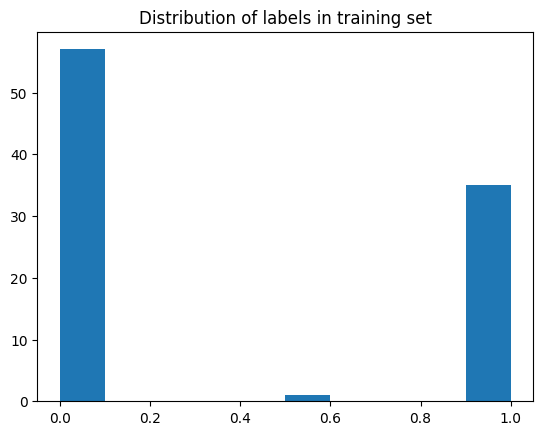

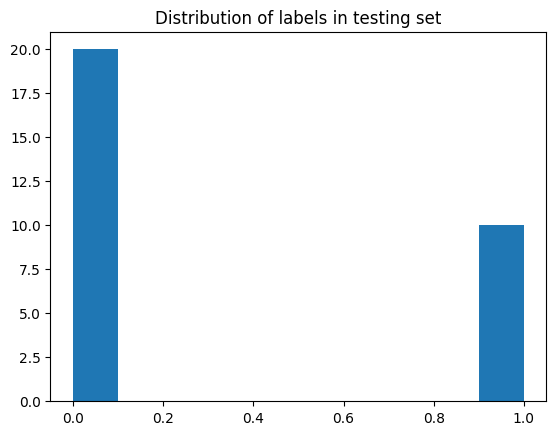

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
22491
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

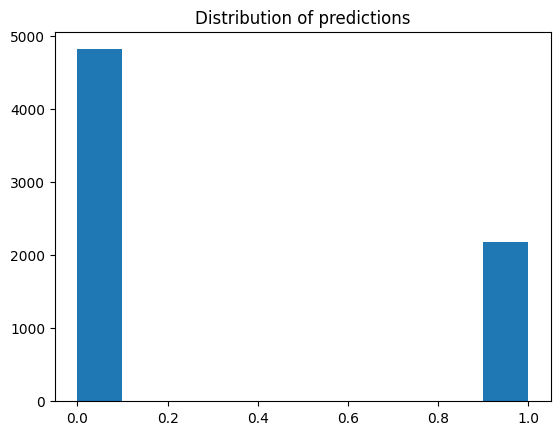

(array([0., 1.]), array([4821, 2179], dtype=int64))
Accuracy: 0.5871428847312927


In [60]:
# Test the function
loss, accuracy, model2 = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500, batch_size=500)

print("Accuracy:", accuracy)

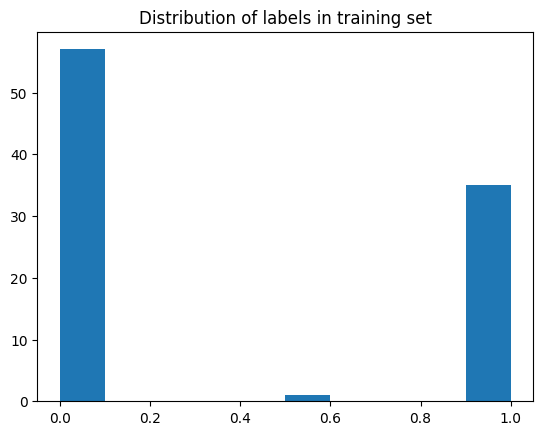

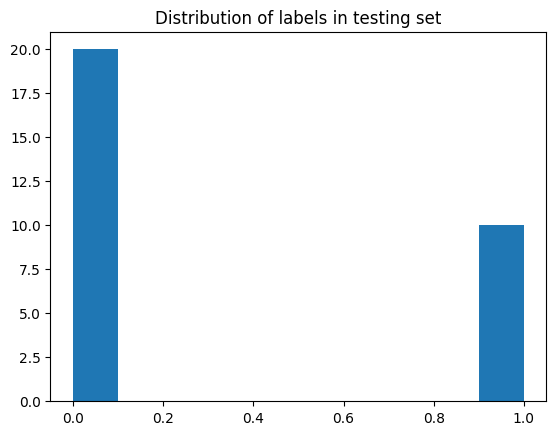

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
2756
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow te

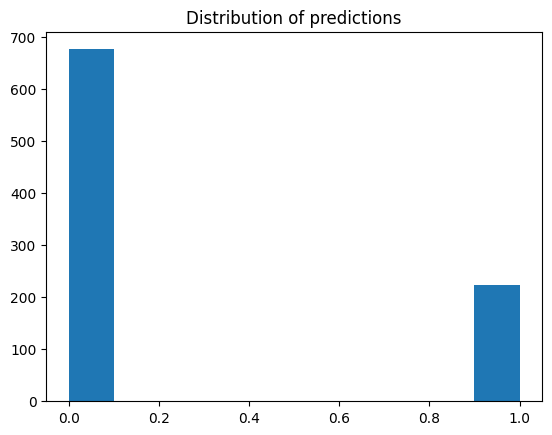

(array([0., 1.]), array([677, 223], dtype=int64))
Accuracy: 0.5633333325386047


In [64]:
# Test the function
loss, accuracy, model2 = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 5000, 4000, batch_size=50)

print("Accuracy:", accuracy)

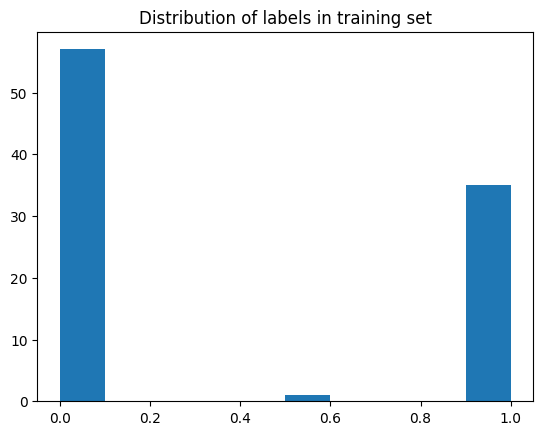

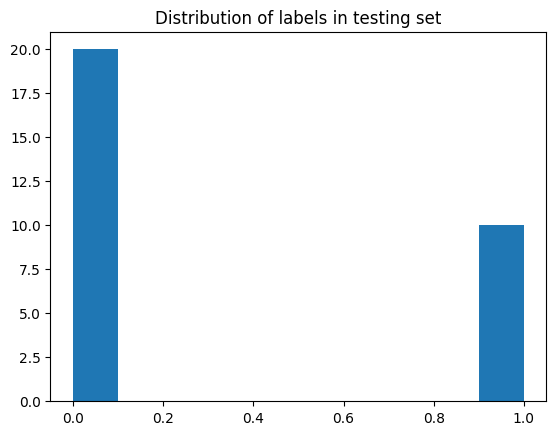

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
2121
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow te

In [7]:
# Test the function
loss, accuracy, model2 = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], 10000, 5000, batch_size=50)

print("Accuracy:", accuracy)

Processing window size 100, stride fraction 0.5, batch size 1000


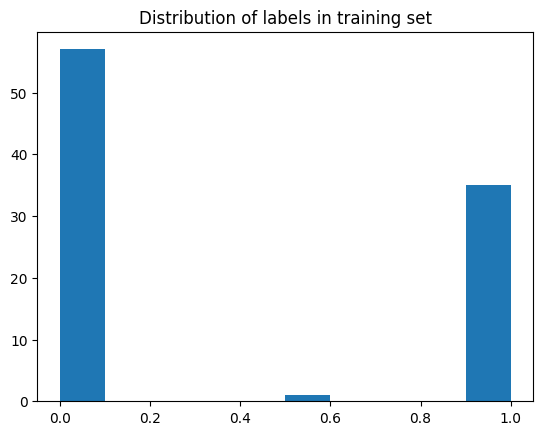

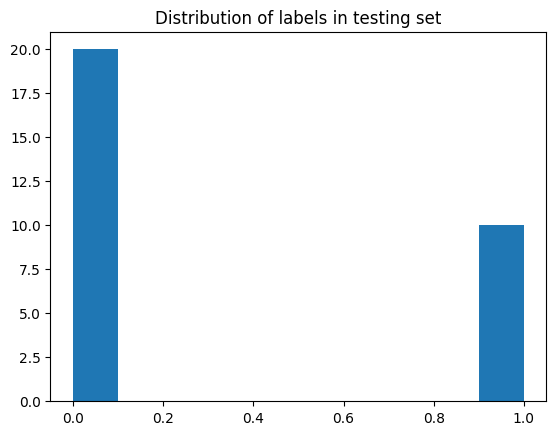

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
226197
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow 

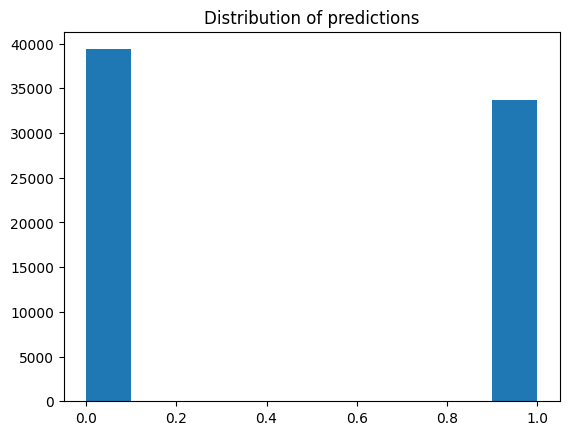

(array([0., 1.]), array([39360, 33640], dtype=int64))
Processing window size 100, stride fraction 1.0, batch size 1000


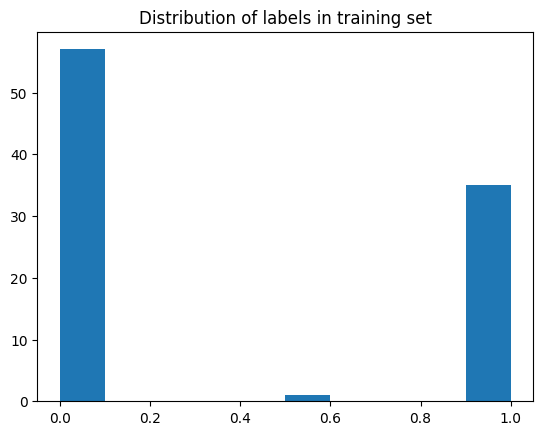

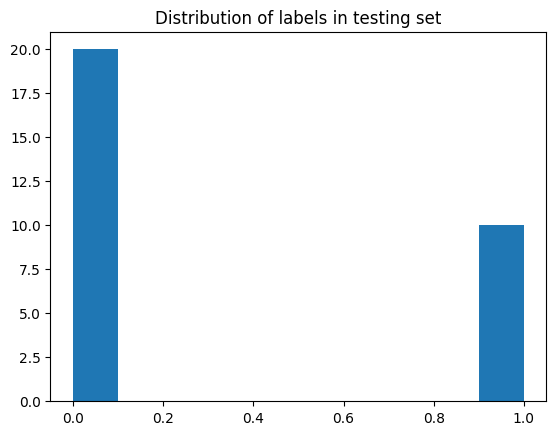

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
113120
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow 

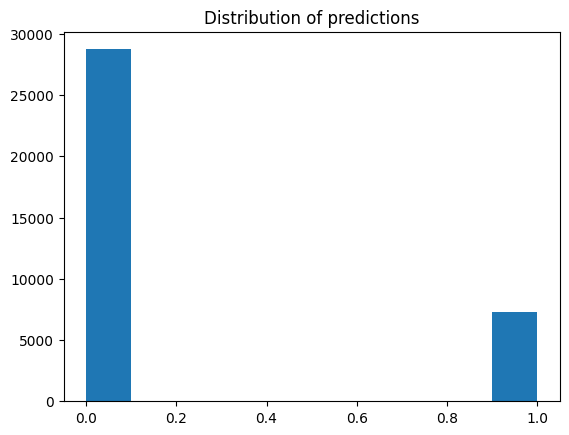

(array([0., 1.]), array([28733,  7267], dtype=int64))
Processing window size 500, stride fraction 0.5, batch size 500


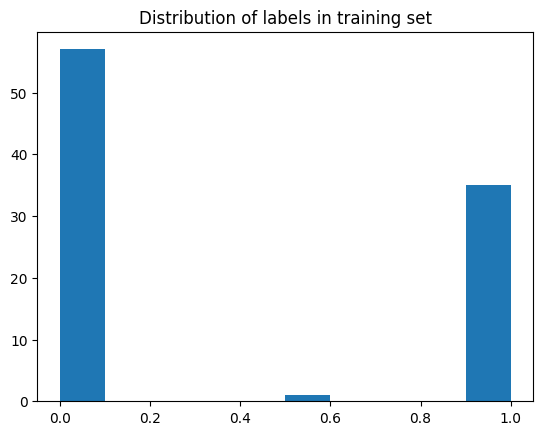

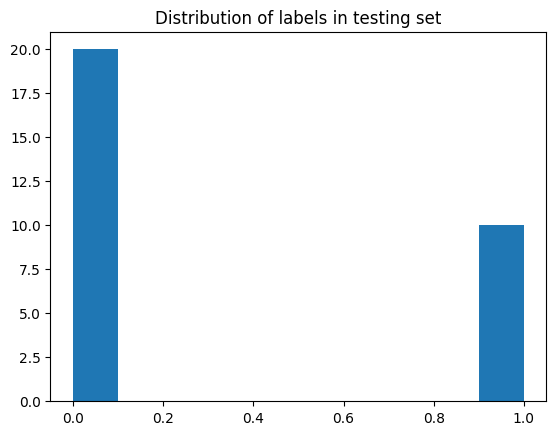

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
45126
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

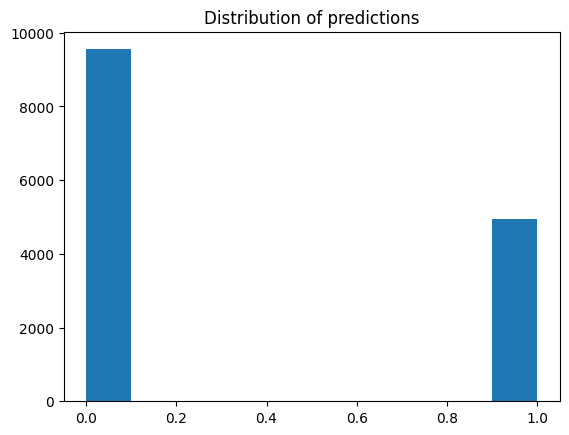

(array([0., 1.]), array([9550, 4950], dtype=int64))
Processing window size 500, stride fraction 0.5, batch size 1000


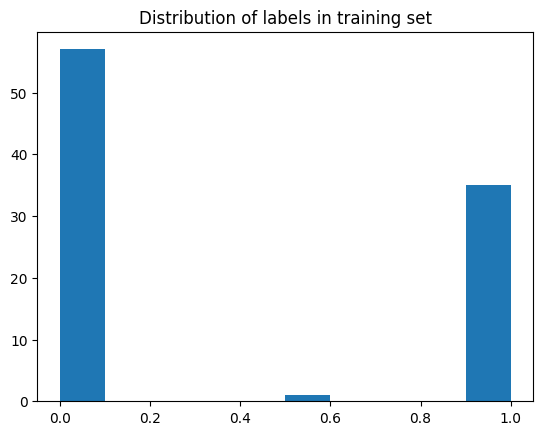

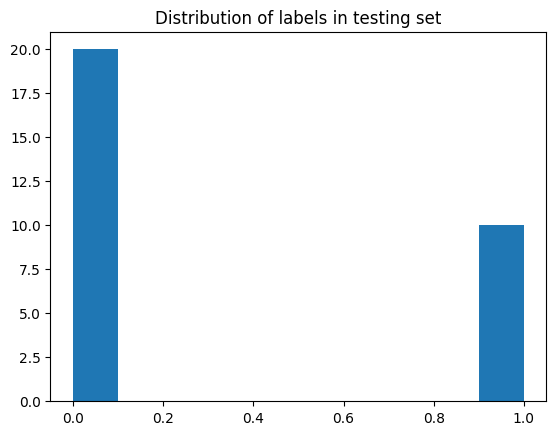

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Number of unique classes: 3
45126
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow t

KeyboardInterrupt: 

In [6]:
# hyperparameter tuning
# window sizes
window_sizes = [100, 500, 1000, 5000, 7500, ]

# stride sizes
# Make stride size a fraction of window size
stride_fractions = [ 0.5, 1.0]

# batch sizes
batch_sizes = [ 500, 1000]

# create a list to store the results
results = []



# loop through the hyperparameters
for window_size in window_sizes:
    for stride_fraction in stride_fractions:
        for batch_size in batch_sizes:
            if window_size<500 and batch_size<1000:
                continue
            if window_size<1000 and batch_size<500:
                continue
            if window_size<5000 and batch_size<100:
                continue

            print(f'Processing window size {window_size}, stride fraction {stride_fraction}, batch size {batch_size}')
            loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], window_size, int(window_size*stride_fraction), batch_size=batch_size)
            results.append({'window_size': window_size, 'stride_fraction': stride_fraction, 'batch_size': batch_size, 'loss': loss, 'accuracy': accuracy})

# print the results
print(results)

# Find best hyperparameter combo
best_accuracy = 0
best_hyperparameters = {}
for result in results:
    if result['accuracy'] > best_accuracy:
        best_accuracy = result['accuracy']
        best_hyperparameters = result

print(best_hyperparameters)

In [ ]:
# hyperparameter tuning
window_size_values = [100, 1000, 5000]
window_stride_values = [(50, 25), (500, 250), (2500, 20
for window_stride in window_stride_values:
    loss, accuracy, model = batchWindowClassification(accelData['Measurements'], accelData['Abnormal'], window_stride[0], window_stride[1], batch_size=500)
    accuracies.append(accuracy)
    losses.append(loss)

# find the best window_stride
best_window_stride = window_stride_values[np.argmax(accuracies)]
print(f'Best window stride: {best_window_stride}')


In [19]:
model1.save('drive/MyDrive/Models/accelModel1.h5')

In [8]:
# save the model
model.save('drive/MyDrive/Pickles/accelModel.h5')

In [ ]:
# load model
from keras.models import load_model
model = load_model('drive/MyDrive/Pickles/accelModel.h5')

In [16]:
# Test the function
accuracy = windowClassification(accelData['Measurements'], accelData['Abnormal'], 100, 50)
print(accuracy)

Data split into training and testing sets
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Training windows created
Normalising window 0 of 286253
Normalising window 2862 of 286253
Normalising window 5724 of 286253
Normalising window 8586 of 286253
Normalising window 11448 of 286253
Normalising window 14310 of 286253
Normalising window 17172 of 286253
Normalising window 20034 of 286253
Normalising window 22896 of 286253
Normalising window 25758 of 286253
Normalising window 28620 of 286253
Normalising window 31482 of 286253
Normalising window 34344 of 286253
Normalising window 37206 of 286253
Normalising window 40068 of 286253
Normalising window 42930 of 286253
Normalising window 45792 of 286253
Normalising window 48654 of 286253
Normalising window 51516 of 286253
Normalising window 54378 of 286253
Normalising window 57240 of 286253
Normalising window 60102 of 286253
Normalising window 62964 of 286253
Normalising window 65826 of 286253
Normalising window 686

NameError: name 'window' is not defined

In [15]:
# Test the function
accuracy = windowClassification(accelData['Measurements'], accelData['Abnormal'], 100, 50)
print(accuracy)


0.5666666666666667


In [19]:
accuracy = windowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 500)
print(accuracy)


Data split into training and testing sets
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Training windows created
Training windows normalised
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
890/890 [==============================] - 67s 73ms/step - loss: 0.6809 - accuracy: 0.5974
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRA

In [15]:
accuracy = windowClassification(accelData['Measurements'], accelData['Abnormal'], 1000, 100)
print(accuracy)

Data split into training and testing sets
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Training windows created
Normalising window 0 of 142101
Normalising window 1421 of 142101
Normalising window 2842 of 142101
Normalising window 4263 of 142101
Normalising window 5684 of 142101
Normalising window 7105 of 142101
Normalising window 8526 of 142101
Normalising window 9947 of 142101
Normalising window 11368 of 142101
Normalising window 12789 of 142101
Normalising window 14210 of 142101
Normalising window 15631 of 142101
Normalising window 17052 of 142101
Normalising window 18473 of 142101
Normalising window 19894 of 142101
Normalising window 21315 of 142101
Normalising window 22736 of 142101
Normalising window 24157 of 142101
Normalising window 25578 of 142101
Normalising window 26999 of 142101
Normalising window 28420 of 142101
Normalising window 29841 of 142101
Normalising window 31262 of 142101
Normalising window 32683 of 142101
Normalising window 34104 o

MemoryError: Unable to allocate 8.47 GiB for an array with shape (142101, 1000, 16) and data type float32

In [5]:
accuracy = windowClassification(accelData['Measurements'], accelData['Abnormal'], 5000, 100)
print(accuracy)


Data split into training and testing sets
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Training windows created
